In [1]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
from gurobipy import *
from rsome import ro
from rsome import grb_solver as grb
import rsome as rso
from rsome import cpt_solver as cpt

In [2]:
data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"

# Parameters

In [3]:
# import pyepo
# generate data
grid = (5,5) # grid size
num_train = 100 # number of training data
num_feat = 5 # size of feature
num_test = 1000
deg = 1.0 # polynomial degree
e = 0.5 # scale of normal std or the range of uniform. For the error term

lower = 0 # coef lower bound
upper = 1 # coef upper bound
p = num_feat # num of features
d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
num_nodes = grid[0]*grid[0]
alpha = e # scale of normal std or the range of uniform. For the error term
mis = deg # model misspecification
coef_seed = 1

In [4]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
grandparent_directory = os.path.dirname(parent_directory)
DataPath = os.path.dirname(grandparent_directory) + '/Data/Test0326_' + data_generation_process + "/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
print("grandparent_directory:", grandparent_directory)
print("DataPath:", DataPath)
DataPath = DataPath + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_coef_seed="+str(coef_seed)+"/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)

grandparent_directory: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Code_MacBook
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Test0326_SPO_Data_Generation/


# Generate Data

In [5]:
def Prepare_Data(DataPath,lower, upper, p, d, coef_seed,seed_all,num_test, num_train, alpha,mis,data_generation_process):
# #  ****** Coef generation *********
    from Data import data_generation
    data_gen = data_generation()
    # print("W_star = ",W_star[0,:])
    W_star = data_gen.generate_truth(DataPath,lower, upper, p, d, coef_seed,version = 0) 
    
    x_test_all = {}; c_test_all = {}; x_train_all = {}; c_train_all = {}; W_star_all = {}
    for seed in seed_all:
        DataPath_seed = DataPath +"Seed="+str(seed)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        # #  ****** Data generation *********
        x_test_all[seed], c_test_all[seed], x_train_all[seed], c_train_all[seed], W_star_all[seed] = data_gen.generate_samples(seed,DataPath_seed,p, d, num_test, num_train, alpha, W_star, mis, thres = 10, 
                                version = data_generation_process, x_dist = 'normal', e_dist = 'normal', x_low = 0, x_up = 2, x_mean = 2, x_var = 0.025, bump = 100) 
        # print()
    return x_test_all, c_test_all, x_train_all, c_train_all, W_star_all

# EPO(SPO+,...)

In [6]:
# from PYEPO import PyEPO_Method
# epo_runner = PyEPO_Method()
def Implement_EPO(DataPath,seed_all,batch_size,num_epochs,method_names,x_train_all,c_train_all,x_test_all,c_test_all,arcs,epo_runner):
    cost_EPO = {}
    # batch_size = 20
    # num_epochs = 30
    for seed in seed_all:
        DataPath_seed = DataPath +"Seed="+str(seed)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        print("*** seed = ",seed,": Run EPO ******")
        cost_EPO[seed] = epo_runner.run(method_names,DataPath_seed,batch_size,num_feat,grid,num_epochs,\
                                        x_train_all[seed],c_train_all[seed],x_test_all[seed],c_test_all[seed],arcs)
    return cost_EPO

# Obtain DDR estimation

### define network

In [7]:
def _getArcs(grid):
    arcs = []
    for i in range(grid[0]):
        # edges on rows
        for j in range(grid[1] - 1):
            v = i * grid[1] + j
            arcs.append((v, v + 1))
        # edges in columns
        if i == grid[0] - 1:
            continue
        for j in range(grid[1]):
            v = i * grid[1] + j
            arcs.append((v, v + grid[1]))

    arc_index_mapping = {}
    for i in range(len(arcs)):
        arc = arcs[i]
        arc_index_mapping[arc] = i

    return arcs,arc_index_mapping

In [8]:
def solve_DDR(arcs,lamb,mu_fixed,num_nodes,x_train,c_train):
    
    N,p = x_train.shape
    N,d = c_train.shape

    # DDR
    m = Model("ddr")
    #m.setParam("DualReductions",0)
    m.setParam('OutputFlag', 0)

    W_ind = tuplelist( [(i,j) for i in range(d) for j in range(p)] )
    w0_ind = tuplelist( [i for i in range(d)])

    W_ddr = m.addVars(W_ind, lb=-GRB.INFINITY,name = "W" )
    w0_ddr = m.addVars(w0_ind, lb=-GRB.INFINITY,name = "W0" )
    alpha = m.addVars(N,num_nodes,lb=-GRB.INFINITY,name="alpha")
    expr_obj = 0
    err = []
    for n in range(N):
        cost_true_tem = c_train[n]
        expr_obj = expr_obj + alpha[n,num_nodes-1] - alpha[n,0]
        for ind in range(len(arcs)):
            cost_pred_tem = quicksum([W_ddr[ind,j] * x_train[n,j] for j in range(p)]) + w0_ddr[ind]
            err.append(cost_true_tem[ind] - cost_pred_tem)
            e = arcs[ind]
            j = e[1]
            i = e[0]
            # print("j = ",j,", i = ",i, ", e = ",e)
            m.addConstr(alpha[n,j] - alpha[n,i] >= -mu_fixed*cost_true_tem[ind] - (1-mu_fixed)*cost_pred_tem)

    m.setObjective(quicksum([err[k] * err[k] for k in range(len(err))])/N + lamb*(expr_obj)/N, GRB.MINIMIZE)
    m.optimize()
    
    W_DDR_rst = m.getAttr('x', W_ddr)
    w0_DDR_rst = m.getAttr('x', w0_ddr)
    W_ddr_val = []
    for i in range(d):
        W_ddr_val.append([W_DDR_rst[(i,j)] for j in range(p)])
    w0_ddr_val = [w0_DDR_rst[i] for i in range(d)]

    alpha_rst = m.getAttr('x', alpha)
    return w0_ddr_val,W_ddr_val,alpha_rst,m.ObjVal

# Out-of-sample performance

### Generate data

In [9]:
arcs,arc_index_mapping = _getArcs(grid)
num_arcs = len(arcs)
seed_all = np.arange(1,20)
# obtain data
x_test_all, c_test_all, x_train_all, c_train_all, W_star_all = Prepare_Data(DataPath,lower, upper, p, d, coef_seed,seed_all,num_test, num_train, alpha,mis,data_generation_process)

### EPO performance

In [50]:
# EPO, including SPO, PG, LTR
batch_size = 20
num_epochs = 30
method_names = ["spo+","pg","ltr"]

from PYEPO import PyEPO_Method
epo_runner = PyEPO_Method()
cost_EPO_all = Implement_EPO(DataPath,seed_all,batch_size,num_epochs,method_names,x_train_all,c_train_all,x_test_all,c_test_all,arcs,epo_runner)

*** seed =  1 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2326.43it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3207.72it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  2 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2237.83it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3216.49it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  3 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1831.47it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3162.90it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  4 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3048.52it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3161.23it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  5 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2197.71it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3166.79it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  6 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2171.13it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3165.98it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  7 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2047.59it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3280.57it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  8 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2021.30it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3251.38it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  9 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2171.65it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3252.75it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  10 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2174.19it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3227.87it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  11 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2064.16it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3251.17it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  12 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2012.19it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3251.91it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  13 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2026.22it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3162.67it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  14 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2066.24it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3273.32it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  15 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2052.80it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3204.02it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  16 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1945.55it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3165.72it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  17 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1952.86it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3194.71it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  18 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1909.27it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3174.55it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2
*** seed =  19 : Run EPO ******
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2186.22it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3214.86it/s]


=========== Run SPO =============
Num of cores: 2
=========== Run PG =============
Num of cores: 2
=========== Run LTR =============
Num of cores: 2


### OLS performance

In [11]:
from OLS import ols_method
ols_method_obj = ols_method()
from Peformance import performance_evaluation
perfs = performance_evaluation()
W_ols_all = {}; w0_ols_all = {}; t_ols_all = {}; obj_ols_all = {}
cost_OLS_all = {}; cost_Oracle_all = {}

for seed in seed_all:
    # compute OLS performance
    W_ols_all[seed], w0_ols_all[seed], t_ols_all[seed], obj_ols_all[seed] = ols_method_obj.ols_solver("",x_train_all[seed], c_train_all[seed])
    cost_OLS_all[seed] = perfs.compute_Cost_with_Prediction(arcs,w0_ols_all[seed],W_ols_all[seed], grid,c_test_all[seed],x_test_all[seed])
    cost_Oracle_all[seed] = perfs.compute_Oracel_Cost(arcs, grid,c_test_all[seed])

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13


In [35]:
DataPath

'/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Test0326_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=40_coef_seed=1/'

### DDR performance

In [12]:
def obtain_DDR_out_of_sample_performance(mu,lamb_all,num_nodes,x_train,c_train,x_test,c_test,cost_OLS,cost_Oracle,perfs):

    regret_arr = np.zeros(len(lamb_all))
    lamb_index = 0
    cost_DDR = {}; w0_ddr_dict = {}; W_ddr_dict = {}
    for lamb in lamb_all:
        w0_ddr_dict[lamb],W_ddr_dict[lamb],alpha_rst,obj_ddr = solve_DDR(arcs,lamb,mu,num_nodes,x_train,c_train)
        cost_DDR[lamb] = perfs.compute_Cost_with_Prediction(arcs,w0_ddr_dict[lamb],W_ddr_dict[lamb], grid,c_test,x_test)
        regret_arr[lamb_index] = (np.nanmean(cost_OLS) - np.nanmean(cost_DDR[lamb]) )/(np.nanmean(cost_OLS) - np.nanmean(cost_Oracle)) * 100
        lamb_index = lamb_index + 1
        # print("seed=",seed,",mu=",mu_fixed,",lamb=",lamb,",obj_ddr=",obj_ddr,",regret=",regret_arr[lamb_index])
    return regret_arr,cost_DDR,w0_ddr_dict,W_ddr_dict

In [13]:
mu = 0.5
mu_all = [0.1,0.3,0.5,0.7,0.9]
lamb_all = np.round(np.arange(0.1,1.5,0.1),2)
regret_all = {}; cost_DDR_all = {}; w0_ddr_all = {}; W_ddr_all = {}
for mu in mu_all:
    for seed in seed_all:
        regret_all[seed,mu],cost_DDR_all[seed,mu],w0_ddr_all[seed,mu],W_ddr_all[seed,mu] = obtain_DDR_out_of_sample_performance(mu,lamb_all,num_nodes,x_train_all[seed],c_train_all[seed],x_test_all[seed],c_test_all[seed],cost_OLS_all[seed],cost_Oracle_all[seed],perfs)
        print("seed=",seed,",mu=",mu,"regret=",np.round(regret_all[seed,mu],4))

seed= 1 ,mu= 0.1 regret= [  0.4701   0.7214  -0.2966  -0.9088  -3.0514  -4.2595  -4.2775  -6.0669
  -7.0773  -9.6707 -12.531  -15.6812 -17.7946 -18.7969]
seed= 2 ,mu= 0.1 regret= [  0.8308   1.1914   0.6035  -0.7756   0.3529  -0.6734  -1.4169  -1.5211
  -2.7258  -4.7665  -5.3963  -6.7758  -8.7365 -10.3434]
seed= 3 ,mu= 0.1 regret= [  0.0251  -0.5195  -2.5284  -2.8362  -4.9602  -5.7796  -7.1804  -8.4181
  -9.7051 -11.7744 -12.7865 -15.1233 -15.4442 -16.4014]
seed= 4 ,mu= 0.1 regret= [  0.2088   0.4704   0.6452  -3.2736  -4.6467  -6.6227  -9.6956 -11.2025
 -12.1714 -13.5307 -14.3373 -16.24   -18.4208 -20.0974]
seed= 5 ,mu= 0.1 regret= [ -0.8117  -2.0293  -2.7369  -3.5961  -5.407   -5.4943  -6.397  -10.7624
 -15.1067 -19.2314 -21.0889 -24.0159 -25.2469 -27.1044]
seed= 6 ,mu= 0.1 regret= [  0.0527   0.4191  -0.5689  -1.8132  -3.4669  -5.1026  -4.9085  -6.6816
  -9.1438  -9.4854 -11.6068 -13.6757 -15.8173 -17.6277]
seed= 7 ,mu= 0.1 regret= [  0.3774  -0.7431  -0.9409  -1.3576  -3.607   -4.8

In [39]:
with open(DataPath+'cost_OLS_all.pkl', "wb") as tf:
    pickle.dump(cost_OLS_all,tf)
with open(DataPath+'cost_Oracle_all.pkl', "wb") as tf:
    pickle.dump(cost_Oracle_all,tf)
with open(DataPath+'cost_DDR_all.pkl', "wb") as tf:
    pickle.dump(cost_DDR_all,tf)

In [14]:
seed = 1
lamb = 1
cost_OLS_esti = x_test_all[seed] @ np.asarray(W_ols_all[seed]).T + w0_ols_all[seed]
cost_DDR_esti = x_test_all[seed] @ np.asarray(W_ddr_all[seed,mu][lamb]).T + w0_ddr_all[seed,mu][lamb]

S_test_index = 3
print("cost_DDR_esti=",np.round(cost_DDR_esti[S_test_index,],2))
# print("cost:(0,1)-->(1,3) = ",cost_DDR_esti[S_test_index,0] + cost_DDR_esti[S_test_index,2])
# print("cost:(0,2)-->(2,3) = ",cost_DDR_esti[S_test_index,1] + cost_DDR_esti[S_test_index,3])

print("cost_OLS_esti=",np.round(cost_OLS_esti[S_test_index,],2))
# print("cost:(0,1)-->(1,3) = ",cost_OLS_esti[S_test_index,0] + cost_OLS_esti[S_test_index,2])
# print("cost:(0,2)-->(2,3) = ",cost_OLS_esti[S_test_index,1] + cost_OLS_esti[S_test_index,3])


print("cost_Oracle=",np.round(c_test_all[seed][S_test_index],2))
# print("cost:(0,1)-->(1,3) = ",c_test_all[seed][S_test_index,0] + c_test_all[seed][S_test_index,2])
# print("cost:(0,2)-->(2,3) = ",c_test_all[seed][S_test_index,1] + c_test_all[seed][S_test_index,3])

cost_DDR_esti= [1.29 1.16 1.4  1.28 1.49 1.37 1.18 1.24 1.46 1.36 1.1  1.15 1.13 1.31
 1.37 1.32 1.49 1.56 1.21 1.18 1.18 1.39 1.23 1.46 1.14 1.32 1.42 1.08
 1.29 1.18 1.22 1.39 1.33 1.22 1.17 1.29 1.5  1.37 1.1  1.32]
cost_OLS_esti= [1.26 1.14 1.4  1.28 1.48 1.35 1.17 1.23 1.46 1.36 1.09 1.15 1.12 1.3
 1.36 1.3  1.49 1.55 1.2  1.16 1.17 1.38 1.23 1.45 1.12 1.3  1.41 1.08
 1.28 1.17 1.2  1.39 1.33 1.22 1.15 1.26 1.5  1.37 1.09 1.3 ]
cost_Oracle= [1.65 1.19 1.31 0.8  1.41 0.84 0.9  0.74 1.95 1.56 1.09 1.71 1.75 1.18
 1.37 0.72 1.61 1.79 1.11 1.33 0.79 1.77 1.17 1.67 1.6  1.96 1.24 1.05
 1.45 0.93 1.68 1.87 1.93 1.28 1.49 1.27 1.56 1.8  1.37 0.79]


In [15]:
regret_avg = np.zeros(len(lamb_all))
for seed in seed_all:
    regret_avg = regret_avg + regret_all[seed,mu]
regret_avg = regret_avg/(len(seed_all))
print("regret_avg=",np.round(regret_avg,4))

regret_avg= [-0.0213  0.0146  0.0771  0.14    0.1855  0.2804  0.3239  0.4699  0.3423
  0.3535  0.231   0.265   0.117   0.1128]


# Plot figures

In [16]:
def cross_compare2plus(c_item, c_base, c_oracle):
    c_item = np.asarray(c_item)
    c_base = np.asarray(c_base)
    c_oracle = np.asarray(c_oracle)

    N = len(c_item)
    c_diff = c_item - c_base
    lbel = np.zeros((N,1))
    
    equals = np.sum(c_diff == 0)
    wins = np.sum(c_diff < 0)
    lose = np.sum(c_diff > 0)
    
    lbel[c_diff < 0] = 1
    lbel[c_diff > 0] = -1
    
    # print("Num_train =",N,",Num_equals =",equals,",Num_wins =",wins,",Num_lose =",lose)
    # print("base cost = ", np.mean(c_base),",item cost = ",np.mean(c_item))
    if N == equals:
        win_ratio = 0.5
    else:
        win_ratio = wins/(N - equals)
    # cost_reduction = (np.mean(c_base) - np.mean(c_item) )/np.abs(np.mean(c_oracle))
    regret_reduction = (np.nanmean(c_base) - np.nanmean(c_item))/np.abs(np.nanmean(c_base) - np.nanmean(c_oracle))
    return lbel, win_ratio, regret_reduction

In [53]:
H2H_DDR_vs_OLS_all = {}; regret_reduction_DDR_vs_OLS_all = {}
for mu in mu_all:
    for lamb in lamb_all:
        H2H_DDR_vs_OLS_arr = np.zeros(len(seed_all)); regret_reduction_DDR_vs_OLS_arr = np.zeros(len(seed_all))
        seed_index = 0
        # print("lamb = ",lamb)
        for seed in seed_all:
            lbel, H2H_DDR_vs_OLS_arr[seed_index], regret_reduction_DDR_vs_OLS_arr[seed_index] = cross_compare2plus(cost_DDR_all[seed,mu][lamb],cost_OLS_all[seed], cost_Oracle_all[seed])
            seed_index = seed_index + 1
        H2H_DDR_vs_OLS_all[mu,lamb] = H2H_DDR_vs_OLS_arr; regret_reduction_DDR_vs_OLS_all[mu,lamb] = regret_reduction_DDR_vs_OLS_arr

In [22]:
lamb_all

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4])

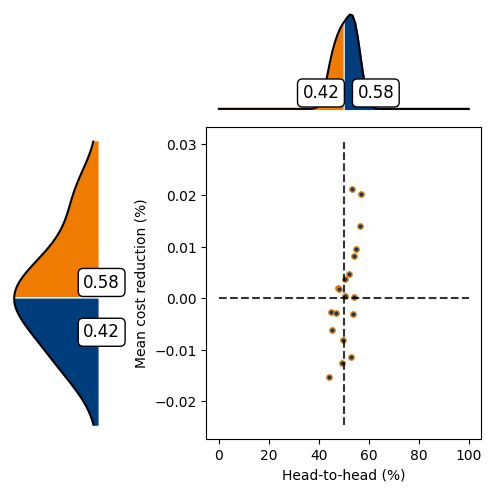

In [34]:
mu = 0.1
lamb = 0.1
import Figures
Figures.figure_plot_upleft(H2H_DDR_vs_OLS_all[mu,lamb]*100, regret_reduction_DDR_vs_OLS_all[mu,lamb], "", size = (5, 5), move = [-0.12, 0.04, 0.35, 0.55], 
                    ysame = 0, yrange = [6,6], sublabel = '', ypio = 0)

In [20]:
# import matplotlib.pyplot as plt
# fig = plt.figure()
# ax = plt.subplot()
# ax.plot(lamb_all,regret_all[seed,mu])

In [49]:
cost_EPO_all.keys()

dict_keys([1])

In [54]:
H2H_SPO_vs_OLS_arr = np.zeros(len(seed_all)); regret_reduction_SPO_vs_OLS_arr = np.zeros(len(seed_all))
seed_index = 0
for seed in seed_all:
    lbel, H2H_SPO_vs_OLS_arr[seed_index], regret_reduction_SPO_vs_OLS_arr[seed_index] = cross_compare2plus(cost_EPO_all[seed]["SPO"],cost_OLS_all[seed], cost_Oracle_all[seed])
    seed_index = seed_index + 1
H2H_SPO_vs_OLS_all = H2H_SPO_vs_OLS_arr; regret_reduction_SPO_vs_OLS_all = regret_reduction_SPO_vs_OLS_arr

In [60]:
print("SPO regret reduction = ",np.nanmean(regret_reduction_SPO_vs_OLS_all))

SPO regret reduction =  -0.1667804750831337


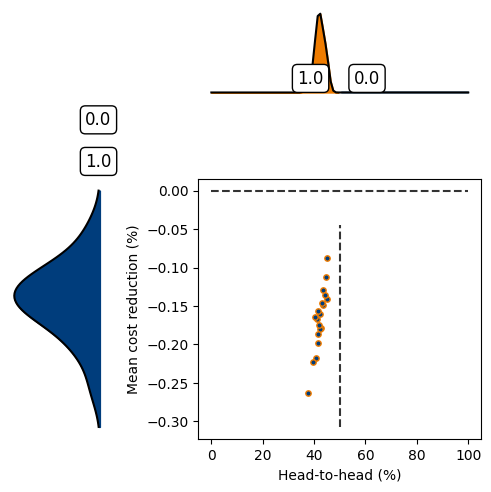

In [56]:
Figures.figure_plot_upleft(H2H_SPO_vs_OLS_all*100, regret_reduction_SPO_vs_OLS_all, "", size = (5, 5), move = [-0.12, 0.04, 0.35, 0.55], 
                    ysame = 0, yrange = [6,6], sublabel = '', ypio = 0)

In [55]:
H2H_SPO_vs_OLS_all

array([0.434, 0.413, 0.378, 0.426, 0.422, 0.434, 0.403, 0.45 , 0.424,
       0.416, 0.415, 0.418, 0.448, 0.406, 0.414, 0.396, 0.43 , 0.442,
       0.452])